READING AND FRAMING DATA (PM2.5 & PM 10) FROM FIDAS 200

In [2]:
import pandas as pd

#Load the FIDAS data
# Adjust the separator based on your file format: tab-delimited
df = pd.read_csv(
    'FIDAS_DATA.txt',
    sep='\t',
    header=0,
    dtype=str  #Load everything as string to ensure control over parsing
)

#Build a proper datetime column 
df['datetime'] = pd.to_datetime(
    df['date'].str.strip() + ' ' + df['time'].str.strip(),
    dayfirst=True,
    errors='coerce'
)

#Drop rows with invalid datetime
df.dropna(subset=['datetime'], inplace=True)

# Convert PM values to numeric 
df['pm25'] = pd.to_numeric(df['PM2.5'], errors='coerce')
df['pm10'] = pd.to_numeric(df['PM10'], errors='coerce')

# Drop rows with missing PM values
df.dropna(subset=['pm25', 'pm10'], inplace=True)

#Filter for July 7–9, 2025
mask = (df['datetime'] >= '2025-07-07') & (df['datetime'] < '2025-07-10')
df_subset = df.loc[mask].copy()

# Round down to hourly timestamps
df_subset['hour'] = df_subset['datetime'].dt.floor('h')

# Group by each hour and compute averages 
fidas = (
    df_subset
      .groupby('hour')[['pm25', 'pm10']]
      .mean()
      .rename(columns={'pm25': 'pm2.5_fidas', 'pm10': 'pm10_fidas'})
      .sort_index()
)

print(fidas)


                     pm2.5_fidas  pm10_fidas
hour                                        
2025-07-07 00:00:00     7.655551    9.162436
2025-07-07 01:00:00     8.691460   10.001117
2025-07-07 02:00:00     5.816341    6.941643
2025-07-07 03:00:00     6.920723    8.458798
2025-07-07 04:00:00     8.737209   10.831236
2025-07-07 05:00:00     5.360234    6.208059
2025-07-07 06:00:00     1.615807    1.911242
2025-07-07 07:00:00     2.043515    2.363016
2025-07-07 08:00:00     3.177291    3.600274
2025-07-07 09:00:00     5.566845    6.238856
2025-07-07 10:00:00     6.148773    7.506386
2025-07-07 11:00:00     5.480676    7.245462
2025-07-07 12:00:00     6.978047    9.495774
2025-07-07 13:00:00     8.420806   11.549124
2025-07-07 14:00:00    10.618623   13.510493
2025-07-07 15:00:00    12.587017   16.057449
2025-07-07 16:00:00     8.999057   11.396823
2025-07-07 17:00:00     9.856146   12.231314
2025-07-07 18:00:00    11.366491   13.231521
2025-07-07 19:00:00     9.364453   11.051777
2025-07-07

READING AND FRAMING DATA (PM2.5 & PM 10) FROM AIR QUALITY SENSOR (AQ_SENSOR)

In [4]:
import json
import pandas as pd

# Load the JSON file
with open("AQ_SENSOR_DATA.txt", "r") as f:
    data = json.load(f)

# Extract hourly records into a DataFrame
records = data["historical"]["hourly"]
df = pd.DataFrame([{
    "datetime": pd.to_datetime(rec["ts"]).tz_convert(None),
    "PM2.5_aqsensor": rec["pm25"]["conc"],
    "PM10_aqsensor": rec["pm10"]["conc"]
} for rec in records])

# Filter for July 7–9, 2025
mask = (df["datetime"] >= "2025-07-07") & (df["datetime"] < "2025-07-10")
df_filtered = df.loc[mask].copy()

# Round down to the hour and group
df_filtered["hour"] = df_filtered["datetime"].dt.floor("h")
hourly_avg = df_filtered.groupby("hour")[["PM2.5_aqsensor", "PM10_aqsensor"]].mean()

print(hourly_avg)


                     PM2.5_aqsensor  PM10_aqsensor
hour                                              
2025-07-07 10:00:00             8.0           12.0
2025-07-07 11:00:00             7.0           10.0
2025-07-07 12:00:00             9.0           15.0
2025-07-07 13:00:00            12.0           21.0
2025-07-07 14:00:00            17.0           29.0
2025-07-07 15:00:00            19.0           34.0
2025-07-07 16:00:00            14.0           24.0
2025-07-07 17:00:00            16.0           27.0
2025-07-07 18:00:00            19.0           31.0
2025-07-07 19:00:00            14.0           22.0
2025-07-07 20:00:00            12.0           18.0
2025-07-07 21:00:00            12.0           18.0
2025-07-07 22:00:00            12.0           20.0
2025-07-07 23:00:00            13.0           22.0
2025-07-08 00:00:00            15.0           23.0
2025-07-08 01:00:00            15.0           24.0
2025-07-08 02:00:00            18.0           28.0
2025-07-08 03:00:00            

MERGE THE HOURLY DATA (PM2.5 & PM10) FROM THE TWO INTRUMENTS

In [5]:
# Merge the data frames into a single data frame
daily_averages = fidas.join(hourly_avg, how='outer').sort_index()
print(daily_averages)

                     pm2.5_fidas  pm10_fidas  PM2.5_aqsensor  PM10_aqsensor
hour                                                                       
2025-07-07 00:00:00     7.655551    9.162436             NaN            NaN
2025-07-07 01:00:00     8.691460   10.001117             NaN            NaN
2025-07-07 02:00:00     5.816341    6.941643             NaN            NaN
2025-07-07 03:00:00     6.920723    8.458798             NaN            NaN
2025-07-07 04:00:00     8.737209   10.831236             NaN            NaN
2025-07-07 05:00:00     5.360234    6.208059             NaN            NaN
2025-07-07 06:00:00     1.615807    1.911242             NaN            NaN
2025-07-07 07:00:00     2.043515    2.363016             NaN            NaN
2025-07-07 08:00:00     3.177291    3.600274             NaN            NaN
2025-07-07 09:00:00     5.566845    6.238856             NaN            NaN
2025-07-07 10:00:00     6.148773    7.506386             8.0           12.0
2025-07-07 1

In [7]:
print(daily_averages.columns)  # Check actual column names

# Ensure column names are correctly spelled and clean
daily_averages.columns = daily_averages.columns.str.strip()  # Removes leading/trailing whitespace

# Then drop rows where either value is NaN
daily_averages_clean = daily_averages.dropna(subset=['pm2.5_fidas', 'PM2.5_aqsensor'])


Index(['pm2.5_fidas', 'pm10_fidas', 'PM2.5_aqsensor', 'PM10_aqsensor'], dtype='object')


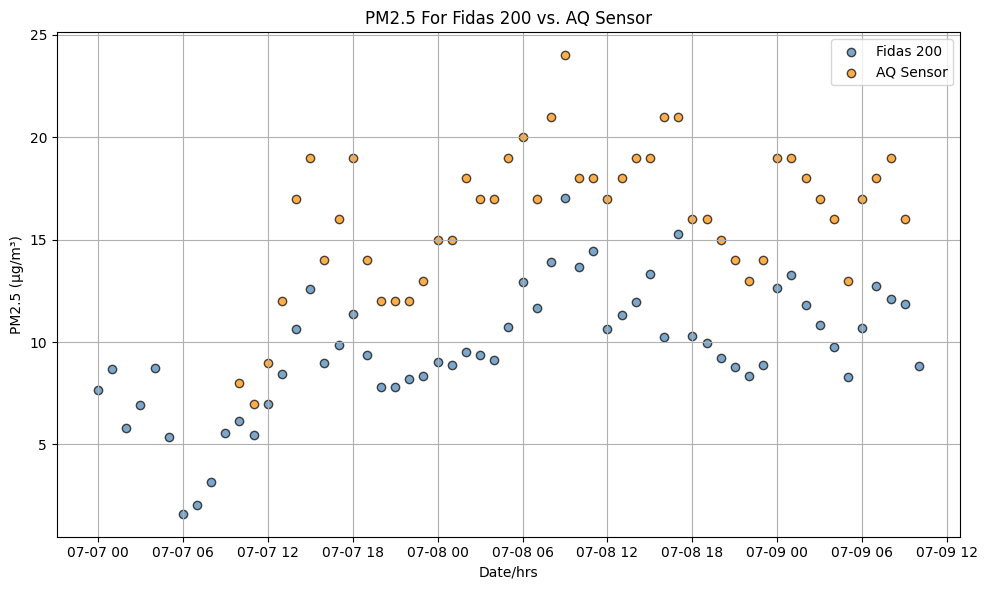

In [15]:
import matplotlib.pyplot as plt

# 1. Prepare clean subsets for each instrument
fidas = daily_averages.dropna(subset=['pm2.5_fidas'])
aq    = daily_averages.dropna(subset=['PM2.5_aqsensor'])

# 2. Plot
plt.figure(figsize=(10, 6))

plt.scatter(
    fidas.index, 
    fidas['pm2.5_fidas'],
    color='steelblue',
    label='Fidas 200',
    alpha=0.7,
    edgecolor='k'
)

plt.scatter(
    aq.index, 
    aq['PM2.5_aqsensor'],
    color='darkorange',
    label='AQ Sensor',
    alpha=0.7,
    edgecolor='k'
)

# 3. Labels & legend
plt.xlabel('Date/hrs')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('PM2.5 For Fidas 200 vs. AQ Sensor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


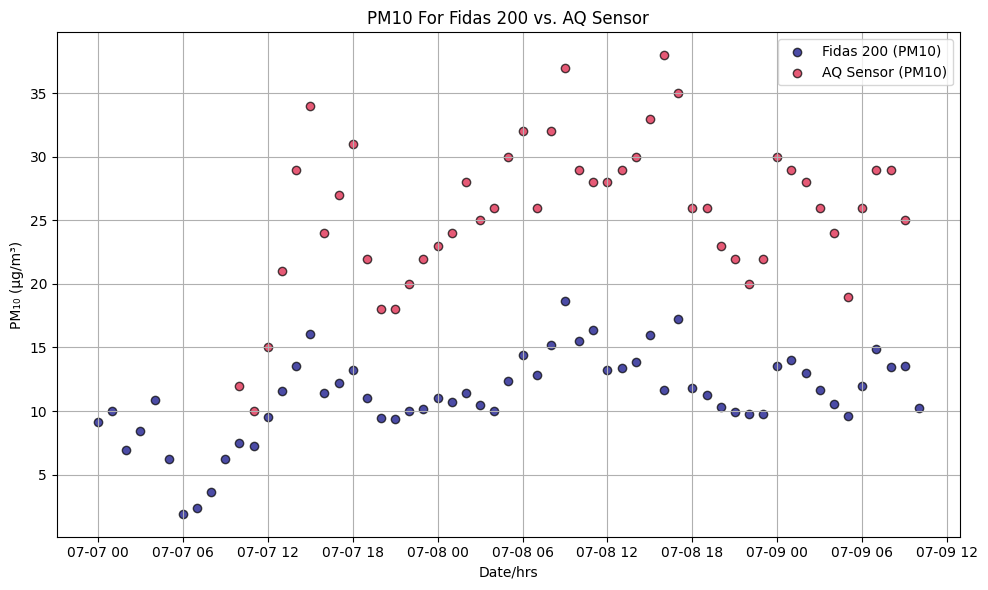

In [17]:
import matplotlib.pyplot as plt

# 1. Prepare clean subsets for each instrument
fidas10 = daily_averages.dropna(subset=['pm10_fidas'])
aq10    = daily_averages.dropna(subset=['PM10_aqsensor'])

# 2. Plot
plt.figure(figsize=(10, 6))

plt.scatter(
    fidas10.index,
    fidas10['pm10_fidas'],
    color='navy',
    label='Fidas 200 (PM10)',
    alpha=0.7,
    edgecolor='k'
)

plt.scatter(
    aq10.index,
    aq10['PM10_aqsensor'],
    color='crimson',
    label='AQ Sensor (PM10)',
    alpha=0.7,
    edgecolor='k'
)

# 3. Labels & legend
plt.xlabel('Date/hrs')
plt.ylabel('PM₁₀ (µg/m³)')
plt.title('PM10 For Fidas 200 vs. AQ Sensor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


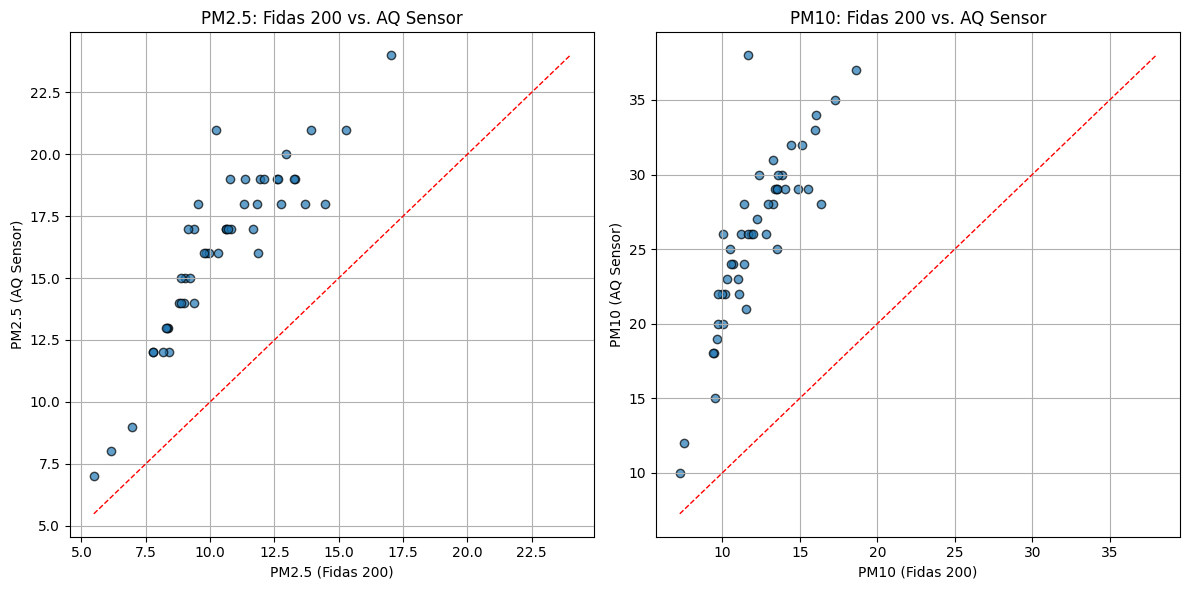

In [8]:
import matplotlib.pyplot as plt

# Clean data for PM2.5 and PM10 separately
da_clean_25 = daily_averages.dropna(subset=['pm2.5_fidas', 'PM2.5_aqsensor'])
da_clean_10 = daily_averages.dropna(subset=['pm10_fidas', 'PM10_aqsensor'])

# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PM2.5 scatter
ax = axes[0]
ax.scatter(
    da_clean_25['pm2.5_fidas'],
    da_clean_25['PM2.5_aqsensor'],
    alpha=0.7,
    edgecolor='k'
)
min25 = min(da_clean_25['pm2.5_fidas'].min(), da_clean_25['PM2.5_aqsensor'].min())
max25 = max(da_clean_25['pm2.5_fidas'].max(), da_clean_25['PM2.5_aqsensor'].max())
ax.plot([min25, max25], [min25, max25], 'r--', linewidth=1)
ax.set_xlabel('PM2.5 (Fidas 200)')
ax.set_ylabel('PM2.5 (AQ Sensor)')
ax.set_title('PM2.5: Fidas 200 vs. AQ Sensor')
ax.grid(True)

# PM10 scatter
ax = axes[1]
ax.scatter(
    da_clean_10['pm10_fidas'],
    da_clean_10['PM10_aqsensor'],
    alpha=0.7,
    edgecolor='k'
)
min10 = min(da_clean_10['pm10_fidas'].min(), da_clean_10['PM10_aqsensor'].min())
max10 = max(da_clean_10['pm10_fidas'].max(), da_clean_10['PM10_aqsensor'].max())
ax.plot([min10, max10], [min10, max10], 'r--', linewidth=1)
ax.set_xlabel('PM10 (Fidas 200)')
ax.set_ylabel('PM10 (AQ Sensor)')
ax.set_title('PM10: Fidas 200 vs. AQ Sensor')
ax.grid(True)

plt.tight_layout()
plt.show()


From the above plots:
PM2.5 comparison
• Points hug the 1:1 line, indicating good agreement overall. 
• The majority lie just above it, so the AQ sensor reports slightly higher PM3.5 than the Fidas 200.

PM10 comparison 
• There’s a bit more scatter than for PM2.5, but still a strong linear trend. 
• Most points sit above the 1:1 line, showing the AQ sensor consistently reads higher PM10 values compared to Fidas 200.